In [1]:
!apt update && apt install -y python3-opencv
!pip install imageio

Selecting previously unselected package libatspi2.0-0:amd64.
Preparing to unpack .../008-libatspi2.0-0_2.30.0-7_amd64.deb ...
Unpacking libatspi2.0-0:amd64 (2.30.0-7) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../009-libxtst6_2%3a1.2.3-1_amd64.deb ...
7Progress: [  6%] [###.......................................................] 8Unpacking libxtst6:amd64 (2:1.2.3-1) ...
Selecting previously unselected package at-spi2-core.
Preparing to unpack .../010-at-spi2-core_2.30.0-7_amd64.deb ...
Unpacking at-spi2-core (2.30.0-7) ...
Selecting previously unselected package libsigsegv2:amd64.
Preparing to unpack .../011-libsigsegv2_2.12-2_amd64.deb ...
Unpacking libsigsegv2:amd64 (2.12-2) ...
Selecting previously unselected package m4.
Preparing to unpack .../012-m4_1.4.18-2_amd64.deb ...
Unpacking m4 (1.4.18-2) ...
Selecting previously unselected package autoconf.
Preparing to unpack .../013-autoconf_2.69-11_all.deb ...
Unpacking autoconf (2.69-11) ...
Sele

# Chess board recognition

Recognition of a chess board and pieces using image processing techniques such as enhancement, filtering and segmentation. Final project for Digital Image Processing course at USP - São Carlos. Our aim is to process the images and reconstruct the FEN (Forsyth-Edwards Notation) of the current match represented on the board.

In [2]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

%matplotlib inline

(843, 1500, 3)


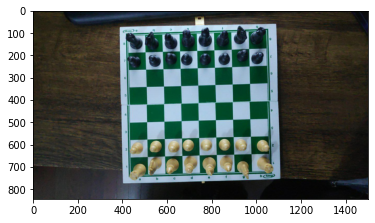

In [106]:
# read and resize the image
img = imageio.imread('my-data/image-20210616-223122.png')
w, h = img.shape[0], img.shape[1]
if w < h:
    w, h = 1500, int(1500 * w / h)
else:
    w, h = int(1500 * h / w), 1500
img = cv2.resize(img, (w, h), interpolation=cv2.INTER_AREA)
print(img.shape)
plt.imshow(img)

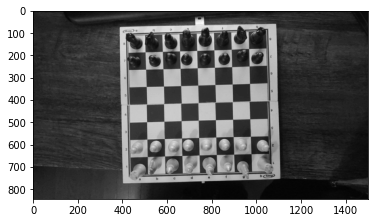

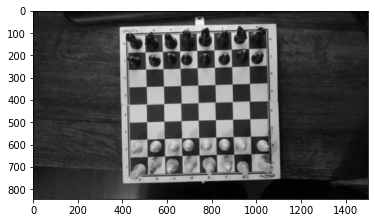

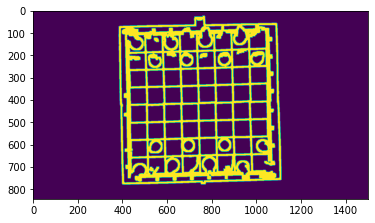

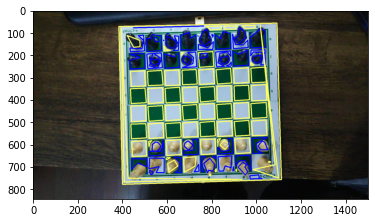

In [108]:
# extract edges
edge_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(edge_img, cmap='gray')
plt.show()
edge_img = cv2.GaussianBlur(edge_img, (5, 5), 2)
plt.imshow(edge_img, cmap='gray')
plt.show()
edge_img = cv2.Canny(edge_img, 20, 200)
edge_img = cv2.dilate(
            edge_img,
            cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10)),
            iterations=1
        )

# find the contours
contours, hierarchy = cv2.findContours(edge_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(edge_img)
plt.show()

# aproximates every contour group to a simpler polygon
for i in range(len(contours)):
    contours[i] = cv2.approxPolyDP(contours[i], 0.04 * cv2.arcLength(contours[i], True), True)

# draw the contours found
image = np.copy(img)
for i, c in enumerate(contours):
    if c.shape[0] <= 1:
        continue
    if len(c) == 4:
        cv2.drawContours(image, contours, i, (255, 255, 100), 3)
    else:
        cv2.drawContours(image, contours, i, (0, 0, 255), 3)
plt.imshow(image)
plt.show()

361.75 0 38


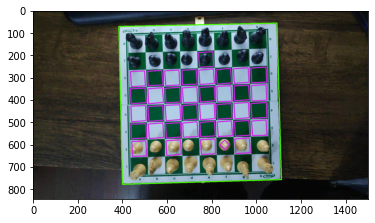

In [104]:
# returns the angle between two vectors ab and ac
def get_angle(ab, ac):
    x = np.clip((ab @ ac) / np.linalg.norm(ab) / np.linalg.norm(ac), -1, 1)
    return np.degrees(np.arccos(x)) if not np.isnan(x) else 0

# check if the set of points form a square
def check_square(points):
    if len(points) != 4:
        return 4 * 90 ** 2, 0
    a, b, c, d = np.squeeze(points)
    bcd = get_angle(b - c, d - c)
    cda = get_angle(c - d, a - d)
    dab = get_angle(d - a, b - a)
    abc = get_angle(a - b, c - b)

    return np.sum((np.array([bcd, cda, dab, abc]) - 90) ** 2), np.mean(np.abs([a - b, b - c, c - d, d - a]))

# count how many squares are inside the square of index i
def child_count(i, hierarchy, is_square):
    j = hierarchy[0, i, 2]
    if j < 0:
        return 0

    total = 0
    while hierarchy[0, j, 0] > 0:
        j = hierarchy[0, j, 0]
    while j > 0:
        if is_square[j]:
            total += 1# + child_count(j, hierarchy, is_square)
        j = hierarchy[0, j, 1]
    return total

# check each contour group to locate squares
square_info = list(map(lambda contour: check_square(contour), contours))
is_square = list(map(lambda info: info[0] < 4 * 10 ** 2 and info[1] > 10, square_info))

# gets the largest square
maxi, idx = 0, -1
squares = []
for i, square_flag, (error, side), contour in zip(range(len(contours)), is_square, square_info, contours):
    if square_flag:
        squares.append(contour)
        if side > maxi:
            maxi, idx = side, i
print(maxi, idx, child_count(idx, hierarchy, is_square))

image = np.copy(img)
cv2.drawContours(image, squares, -1, (207, 35, 229), 3)
cv2.drawContours(image, contours, idx, (70, 255, 0), 3)
plt.imshow(image)

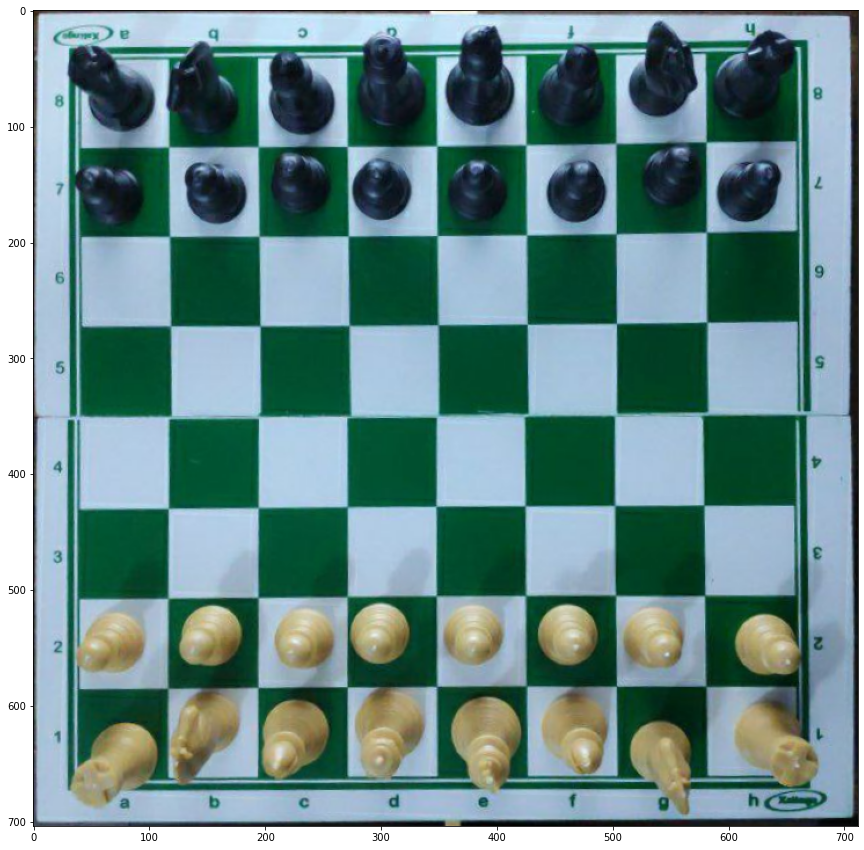

In [105]:
# rotate and crop the image, given the points of the new border
def crop_image(image, points):
    points = np.squeeze(points)
    low, high = points[np.lexsort((points[:, 1], points[:, 0]))[:2]]
    angle = -get_angle(np.array([0, 1]), high - low)
    #image[low[1]-10:low[1]+10, low[0]-10:low[0]+10] = (255, 0, 0)
    #image[high[1]-10:high[1]+10, high[0]-10:high[0]+10] = (0, 255, 255)
    if angle < -90:
        angle, low, high = angle + 180, high, low
    
    rot = cv2.getRotationMatrix2D((int(low[0]), int(low[1])), angle, 1.0)
    h, w = image.shape[:2]
    image = cv2.warpAffine(image, rot, (w, h))
    points = np.concatenate((points, np.ones(points.shape[0]).reshape((-1, 1))), axis=1)
    points = (rot @ points.T).T.astype(np.int32)
    
    image = image[points[:, 1].min():points[:, 1].max(), points[:, 0].min():points[:, 0].max()]
    return image

cropped = crop_image(img, contours[idx])

plt.figure(figsize=(15, 15))
plt.imshow(cropped)
imageio.imwrite('out.png', cropped)

Generating images to show on Partial Report

(-0.5, 711.5, 703.5, -0.5)

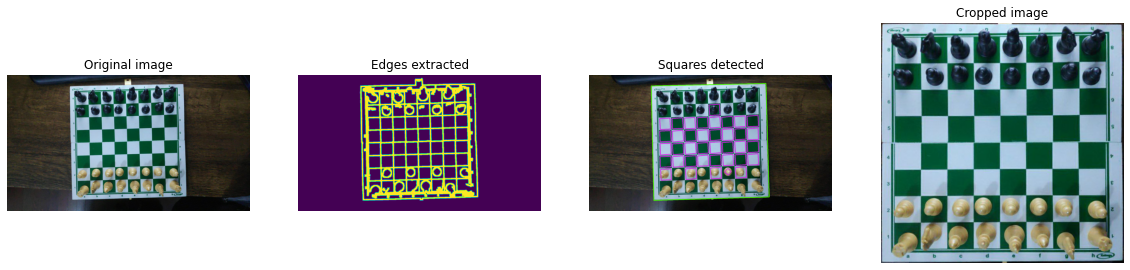

In [107]:
plt.figure(figsize=(20, 6))

plt.subplot(141)
plt.imshow(img)
plt.title('Original image')
plt.axis('off')

plt.subplot(142)
plt.imshow(edge_img)
plt.title('Edges extracted')
plt.axis('off')

plt.subplot(143)
plt.imshow(image)
plt.title('Squares detected')
plt.axis('off')

plt.subplot(144)
plt.imshow(cropped)
plt.title('Cropped image')
plt.axis('off')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a990a5a8-7c3e-4bd5-890f-4e9b644eb2a9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>